In [2]:
# !python3 clear_nbcode.py 03_minibatch_training-Copy1.ipynb

In [ ]:
#export
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [117]:
#export
from exp.nb_02 import *
import torch.nn.functional as F

def pp(*args, n=120):
    for arg in args:
        print(arg)
        print("-"*n)

def stats(x): return x.mean(), x.std()

## Initial setup

### Data

In [4]:
mpl.rcParams['image.cmap'] = 'gray'

In [5]:
x_train, y_train, x_valid, y_valid = get_data()

In [6]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50
pp(n,m,nh, c, type(c.item()))

50000
---------------------------------------------------------------------------
784
---------------------------------------------------------------------------
50
---------------------------------------------------------------------------
tensor(10)
---------------------------------------------------------------------------
<class 'int'>
---------------------------------------------------------------------------


In [7]:
class Model(nn.Module):
        def __init__(self,n_in, n_h, n_out):
            super().__init__()
            self.layers = [nn.Linear(n_in, n_h), nn.ReLU(), nn.Linear(n_h, n_out)]
            
        def __call__(self, x):
            for l in self.layers: x = l(x)
            return x

In [8]:
model = Model(m,nh, 10)

In [9]:
pred = model(x_train)

### Cross entropy loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss.

In [10]:
pp(x_train.shape, x_train.sum(-1, keepdim=True),x_train.sum(-1).shape, x_train.sum(-1, keepdim=True).shape,)

torch.Size([50000, 784])
---------------------------------------------------------------------------
tensor([[107.5195],
        [121.4648],
        [ 75.9492],
        ...,
        [ 90.2383],
        [ 88.0508],
        [104.8672]])
---------------------------------------------------------------------------
torch.Size([50000])
---------------------------------------------------------------------------
torch.Size([50000, 1])
---------------------------------------------------------------------------


In [11]:
def log_softmax(x): return (x.exp()/x.exp().sum(-1, keepdim=True)).log()

In [12]:
sm_pred = log_softmax(pred)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded, this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

This can be done using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing). Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [13]:
pp(sm_pred[:3],y_train[:3],sm_pred.shape)

tensor([[-2.3204, -2.1389, -2.2716, -2.3317, -2.3439, -2.4343, -2.2101, -2.4432,
         -2.3729, -2.2044],
        [-2.2794, -2.2235, -2.1664, -2.4022, -2.4043, -2.4486, -2.2041, -2.4008,
         -2.3817, -2.1700],
        [-2.1483, -2.1156, -2.1930, -2.4397, -2.4728, -2.3758, -2.3533, -2.5087,
         -2.2828, -2.2232]], grad_fn=<SliceBackward>)
---------------------------------------------------------------------------
tensor([5, 0, 4])
---------------------------------------------------------------------------
torch.Size([50000, 10])
---------------------------------------------------------------------------


In [14]:
sm_pred[0][5]

tensor(-2.4343, grad_fn=<SelectBackward>)

In [15]:
sm_pred[[0,1,2], [5,0,4]]

tensor([-2.4343, -2.2794, -2.4728], grad_fn=<IndexBackward>)

In [16]:
y_train.shape[0]

50000

In [17]:
def nll(inp, targ): return -inp[range(targ.shape[0]), targ].mean()

In [18]:
loss = nll(sm_pred, y_train)
loss

tensor(2.3112, grad_fn=<NegBackward>)

Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax, which was previously defined as `(x.exp()/(x.exp().sum(-1,keepdim=True))).log()`

In [27]:
def log_softmax(x): return x - x.exp().sum(-1, keepdim=True).log()

In [28]:
test_near(nll(log_softmax(pred), y_train), loss)

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [29]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us. 

In [30]:
test_near(logsumexp(pred), pred.logsumexp(-1))

So we can use it for our `log_softmax` function.

In [31]:
def log_softmax(x): return x - x.logsumexp(-1, keepdim=True)

In [32]:
test_near(nll(log_softmax(pred), y_train), loss)

Then use PyTorch's implementation.

In [33]:
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [34]:
test_near(F.cross_entropy(pred, y_train), loss)

## Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [50]:
pred.shape

torch.Size([50000, 10])

In [51]:
loss_func = F.cross_entropy

In [52]:
#export 
def accuracy(out, y_b): return (torch.argmax(out, dim=1) == y_b).float().mean()

In [53]:
bs = 64 #batch_size
xb = x_train[:bs] # a minibatch from x
preds = model(xb) # predictions
pp(preds[0], preds.shape)

tensor([ -3.2621,  -2.2927,   1.1737,   8.5660, -13.1622,  14.7038,  -3.2087,
         -3.4031,  -2.3621,   1.0687], grad_fn=<SelectBackward>)
---------------------------------------------------------------------------
torch.Size([64, 10])
---------------------------------------------------------------------------


In [54]:
yb = y_train[:bs]
loss_func(preds, yb)

tensor(0.1429, grad_fn=<NllLossBackward>)

In [55]:
accuracy(preds, yb)

tensor(0.9375)

In [56]:
lr = 0.5
epochs = 1

In [57]:
# our basic training loop
for i in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i + bs
        x_b = x_train[start_i:end_i]
        y_b = y_train[start_i:end_i]
        loss = loss_func(model(x_b), y_b)
        loss.backward()       
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [58]:
pp(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.1690, grad_fn=<NllLossBackward>)
---------------------------------------------------------------------------
tensor(0.9375)
---------------------------------------------------------------------------


## Using parameters and optim

### Parameters

Use `nn.Module.__setattr__` and move relu to functional:

In [59]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __call__(self, x):
        return self.l2(F.relu(self.l1(x)))

In [60]:
model = Model(m, nh, c.item()) # c is a torch tensor, we need to grab integer from it

In [61]:
for name, l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [62]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [63]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [66]:
def fit():
    for i in range(epochs):
        for i in range((n-1)//bs +1):
            start_i = i*bs
            end_i = start_i + bs
            x_b = x_train[start_i:end_i]
            y_b = y_train[start_i: end_i]
            loss = loss_func(model(x_b), y_b)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [69]:
fit()
pp(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.1725, grad_fn=<NllLossBackward>)
---------------------------------------------------------------------------
tensor(0.9375)
---------------------------------------------------------------------------


Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

In [99]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v  # startswith is a builtin string function
        super().__setattr__(k,v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [100]:
# differences between yield and return stmt
def yld():
    for i in range(5): yield i
def rtn():
    for i in range(5): return i

pp(yld(),[i for i in yld()], rtn())

<generator object yld at 0x7f11d483dbf8>
---------------------------------------------------------------------------
[0, 1, 2, 3, 4]
---------------------------------------------------------------------------
0
---------------------------------------------------------------------------


In [101]:
mdl = DummyModule(m, nh, c.item())
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [102]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

### Registering modules

We can use the original `layers` approach, but we have to register the modules.

without layers registration

In [103]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh, c.item())]

In [104]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [105]:
model = Model(layers)

In [106]:
model

Model()

with layers registration

In [109]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers): self.add_module(f'layer{i}', l)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [110]:
model = Model(layers)

In [111]:
model

Model(
  (layer0): Linear(in_features=784, out_features=50, bias=True)
  (layer1): ReLU()
  (layer2): Linear(in_features=50, out_features=10, bias=True)
)

In [115]:
fit()
pp(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.1251, grad_fn=<NllLossBackward>)
---------------------------------------------------------------------------
tensor(0.9531)
---------------------------------------------------------------------------


### nn.ModuleList

`nn.ModuleList` does this for us.

In [112]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [113]:
model = Model(layers)

In [114]:
model 

Model(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

### nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [118]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh, c.item()))

In [119]:
fit()
pp(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.1575, grad_fn=<NllLossBackward>)
------------------------------------------------------------------------------------------------------------------------
tensor(0.9531)
------------------------------------------------------------------------------------------------------------------------


In [120]:
nn.Sequential??

In [121]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

### optim

Let's replace our previous manually coded optimization step:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

and instead use just:

```python
opt.step()
opt.zero_grad()
```

In [122]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params, self.lr = list(params), lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad*lr
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [123]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh, c.item()))

In [124]:
opt = Optimizer(model.parameters())

In [126]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i + bs
            x_b = x_train[start_i: end_i]
            y_b = y_train[start_i: end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            opt.step()
            opt.zero_grad()

In [127]:
fit()
pp(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0006, grad_fn=<NllLossBackward>)
------------------------------------------------------------------------------------------------------------------------
tensor(1.)
------------------------------------------------------------------------------------------------------------------------


PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later - except we'll be doing it in a more flexible way!)

In [128]:
#export
from torch import optim

In [133]:
optim.SGD??

In [131]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh, c.item()))
    return model, optim.SGD(model.parameters(), lr=lr)

In [132]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.3152, grad_fn=<NllLossBackward>)

In [ ]:
fit()

In [141]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
pp(loss, acc)

tensor(0.0006, grad_fn=<NllLossBackward>)
------------------------------------------------------------------------------------------------------------------------
tensor(1.)
------------------------------------------------------------------------------------------------------------------------


Randomized tests can be very useful.

In [142]:
assert acc>0.7

## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[i*bs : i*bs+bs]
```

In [173]:
#export
class Dataset():
    def __init__(self, x, y): self.x, self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self,i): return self.x[i], self.y[i]

In [174]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds)==len(x_valid)

In [175]:
xb, yb = train_ds[0:5]
assert xb.shape == (5, 28*28)
assert yb.shape == (5,)
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [185]:
model, opt = get_model()

In [186]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            x_b, y_b = train_ds[i*bs : i*bs+bs]
            pred = model(x_b)
            loss = loss_func(pred, y_b)

            loss.backward()
            opt.step()
            opt.zero_grad()       

In [187]:
fit()

In [188]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
pp(loss, acc)

tensor(0.0238, grad_fn=<NllLossBackward>)
------------------------------------------------------------------------------------------------------------------------
tensor(1.)
------------------------------------------------------------------------------------------------------------------------


### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

In [189]:
class DataLoader():
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), bs): yield self.ds[i: i+self.bs]

In [190]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [192]:
xb, yb = next(iter(train_dl))
assert xb.shape == (bs, 28*28)
assert yb.shape == (bs,)

tensor(5)

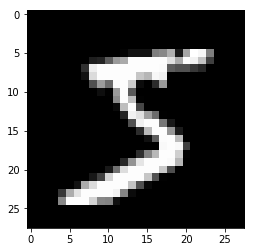

In [193]:
plt.imshow(xb[0].view(28, 28))
yb[0]

In [194]:
model, opt = get_model()

In [195]:
def fit():
    for epoch in range(epochs):
        for x_b, y_b in train_dl:
            pred = model(x_b)
            loss = loss_func(pred, y_b)
            
            loss.backward()
        
            opt.step()
            opt.zero_grad()

In [197]:
fit()
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
pp(loss, acc)

tensor(0.1618, grad_fn=<NllLossBackward>)
------------------------------------------------------------------------------------------------------------------------
tensor(0.9531)
------------------------------------------------------------------------------------------------------------------------


### Random sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [326]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i : i+self.bs]        

In [327]:
small_ds = Dataset(*train_ds[:10])

In [328]:
s = Sampler(small_ds, 3,False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [329]:
s = Sampler(small_ds, 3,True)
[o for o in s]

[tensor([8, 7, 0]), tensor([5, 2, 6]), tensor([9, 1, 4]), tensor([3])]

In [330]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)
    
class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
    
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [331]:
train_smp = Sampler(train_ds, bs, shuffle=True)
valid_smp = Sampler(train_ds, bs, shuffle=False)

In [332]:
train_dl = DataLoader(train_ds, train_smp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, valid_smp, collate_fn = collate)

tensor(3)

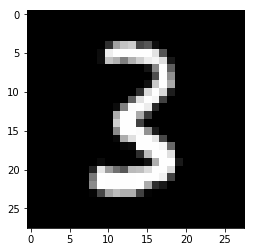

In [333]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28, 28))
yb[0]

tensor(8)

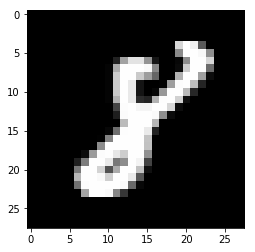

In [334]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28, 28))
yb[0]

tensor(3)

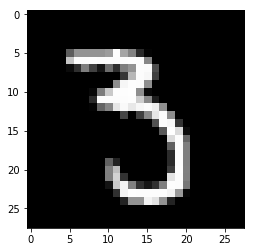

In [335]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28, 28))
yb[0]

In [336]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.3115, grad_fn=<NllLossBackward>), tensor(0.8750))

### PyTorch DataLoader

In [344]:
#export
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [345]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(train_ds), collate_fn=collate)

In [346]:
xb, yb = next(iter(train_dl))

In [347]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0186, grad_fn=<NllLossBackward>), tensor(1.))

PyTorch's defaults work fine for most things however:

In [348]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [349]:
xb, yb = next(iter(valid_dl))

In [350]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1547, grad_fn=<NllLossBackward>), tensor(0.9531))

Note that PyTorch's `DataLoader`, if you pass `num_workers`, will use multiple threads to call your `Dataset`.

## Validation

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [361]:
def fit(epochs, model, loss_func, optim, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle BatchNorm / Dropout
        model.train()
#         print(model.training)
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            optim.step()
            optim.zero_grad()
            
        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            for xb, yb in  valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc += accuracy(pred, yb)
            nv = len(valid_dl)
            print(f"epoch:{epoch}, valid_loss:{tot_loss/nv:.4f}, valid_acc:{tot_acc/nv:.4f}")
    return tot_loss/nv, tot_acc/nv

*Question*: Are these validation results correct if batch size varies?

`get_dls` returns dataloaders for the training and validation sets:

In [366]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs), 
            DataLoader(valid_ds, batch_size=bs, shuffle=False, **kwargs))

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [363]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

epoch:0, valid_loss:0.2041, valid_acc:0.9389
epoch:1, valid_loss:0.2334, valid_acc:0.9227
epoch:2, valid_loss:0.1496, valid_acc:0.9551
epoch:3, valid_loss:0.1023, valid_acc:0.9704
epoch:4, valid_loss:0.1059, valid_acc:0.9713


In [364]:
assert acc>0.7

## Export

In [368]:
!python3 notebook2script.py 03_minibatch_training-Copy1.ipynb

Converted 03_minibatch_training-Copy1.ipynb to exp/nb_03.py
